In [1]:
import all_functions_tda as aftda
%load_ext autoreload
%autoreload 2

Authors:

Alexandr Talitsky 


Andrei Vlasov


Nikolay Shvetsov


Polina Pylugina

In [2]:
import pandas as pd
from ripser import ripser, plot_dgms

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import seaborn as sns
import pickle
from sklearn import datasets
import csv
import numpy as np
import datetime
import random

from ripser import ripser, plot_dgms

# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# import scipy.interpolate as interp

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Loading original data, which has already been preprocessed in forms of persistence diagrams

In the main file with functions there are functions, used in the pipeline for creation of persistence diagrams (PDs). Those functions were previously applied to each dataset and rips filtrations were created, this code was run on separate server, as this task was computationally intense. Here we just load the pickles with olready created persistence diagrams. 

Each pd in the datasets <code>em_PD</code> and <code>rh_PD</code> contain both 0D and 1D homologies, while for our research we need to focus on 1D homologies, following all papers on the topic. We also tryed to extract 2D homologies, but there were none of them for most data, so we did not focus on them.

Additionally, we get rid of diagonal elements (which has died at the moment of the birth), as they are meaningless.

In [3]:
with open('elo_merchant/titles.csv', 'r') as f:
    reader = csv.reader(f)
    em_titles = list(reader)[0]
    
em_PD = aftda.load_pkl('elo_merchant/rips_filtrations') 

rh_titles = aftda.load_pkl('redhat/titles')
rh_PD = aftda.load_pkl('redhat/rips_filtrations') 

And following the paper by Lacombe, we need to discretize PDs: we encode them as histograms on the square, so we can represent them as $d \times d$ square matrices, which makes them more convinient to work with. The encoding process was as folows:
* We calculate the maximum (the most persistent) point among all PDs in given dataset
* We therefore create square matrix $\mathbf{a} \in \mathbb{R}^{d \times d}$, for which each element $a_{ij}$ corresponds to the number of points in original PD, located in cell at position $(i, \: j)$ on the grid
* We then assosiate to each histogram its mass, which corresponds to the number of off-diagonal points in the original PD, and this fact is extremely important feature of this approach

Also here we initialize the parameters for the algorithm, which are:
* $d$ — size of the grid for encoding
* $\gamma$ — smoothing parameter, used in algorithm
* $\lambda$ — learning rate for algorithm 2
* $p$ — order of norm used in computations

In [21]:
d = 100
gamma = 0.2
Lambda = 0.01
p = 2

# we create class, which processes PDs to the needed format automatically
em_pd = aftda.persistence_diagram(em_PD, d, gamma, Lambda) 
rh_pd = aftda.persistence_diagram(rh_PD, d, gamma, Lambda)

### Here we present some visualaization of our data

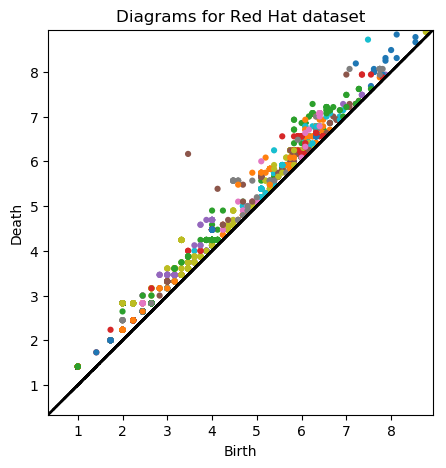

In [12]:
# Carefully! This requires ripser, which is pretty messed up library
plt.figure(figsize = (5, 5), dpi = 100)
for pdg in rh_PD[:500]:
    if len(pdg[1])!= 0:
        plot_dgms(pdg[1], legend = False)
plt.title('Diagrams for Red Hat dataset')
plt.show()

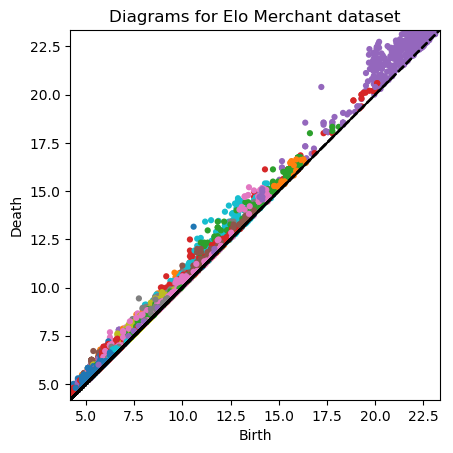

In [13]:
plt.figure(dpi = 100)
for pdg in em_PD[:200]:
    if len(pdg[1])!= 0:
        plot_dgms(pdg[1], legend = False)
plt.title('Diagrams for Elo Merchant dataset')
plt.show()

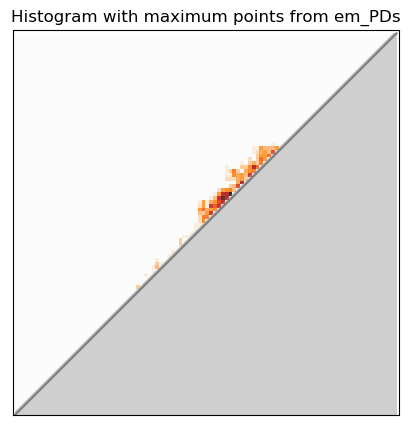

<Figure size 500x500 with 0 Axes>

In [17]:
aftda.plot_histogram(em_pd.histograms[44])
plt.title("Histogram with maximum points from em_PDs")
plt.figure(figsize= (5,5))
plt.show()

# Make synthetic data

In addition to the original data, which is extremely big, we have created histograms with simple blobs, in order to test our approach. We create blobs of different size, in order to check how algoritm incorporates mass in the calculation of distance, and also we use blobs for clustering.

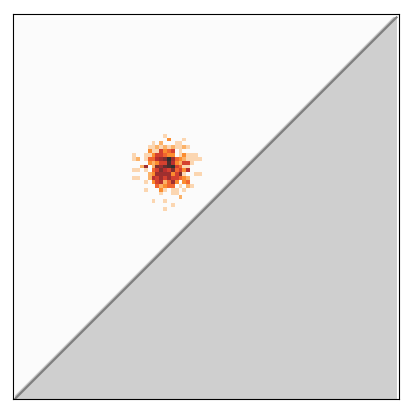

<Figure size 640x480 with 0 Axes>

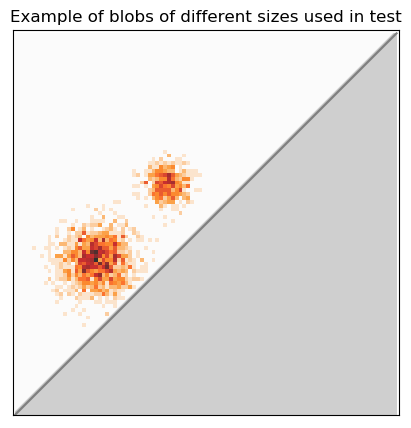

In [18]:
X, y = datasets.make_blobs(n_samples=500, n_features = 2, centers = [(40, 20)], cluster_std=3)
blob_2 = np.ones((d, d))
for x in X:
    i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))
    if (i != j) and (i<j):
        blob_2[i][j] +=1 
aftda.plot_histogram(blob_2)
plt.figure(2)
X, y = datasets.make_blobs(n_samples=1500, n_features = 2, centers = [(20, 2)], cluster_std=5)
blob_1 = np.ones((d, d))
for x in X:
    i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
    if (i != j) and (i<j):
        blob_1[i][j] +=1 
aftda.plot_histogram(blob_1 + blob_2)
plt.title("Example of blobs of different sizes used in test")
plt.savefig('blobs.jpg')
plt.show()

# Finding optimal transport

## Plot kernels, which we used for calculation of optimal transport

As was described in the report, in order to approximate distances we use Sinkhorn map, defined as follows:
$$
    \mathbf{S} \: : \: (u, v) \to \left(\frac{a}{Kv},  \frac{b}{K^{\top}u}\right)
$$
Where kernel matrix $K$ is defined as follows:
\begin{equation}\label{cost_matrices}
    C = \begin{pmatrix}
    \hat{C} & \vec{\mathbf{c}}_{\Delta} \\
    \vec{\mathbf{c}}_{\Delta}^{\top} & 0
    \end{pmatrix}, \:\:\:
    K = \begin{pmatrix}
    \hat{K} := e^{- \frac{\hat{C}}{\gamma}} & \vec{\mathbf{k}}_{\Delta} := e^{- \frac{\vec{\mathbf{c}}_{\Delta}}{\gamma}}\\
    \vec{\mathbf{k}}_{\Delta}^{\top} & 1
    \end{pmatrix}
\end{equation}





$\mathbf{c}_{\Delta} = \left( \| (i, i') - \pi_{\Delta}((i, i')) \|^p_p\right)_{ii'}$ (here $\pi_{\Delta}$ is the projector on the diagonal)

Following the algorithm 1 from Lacombe, we have created the function which calculates optimal transport and included it in the class of persistence diagrams. Here we check whether it gives reasonable results for different and same diagrams from our dataset.

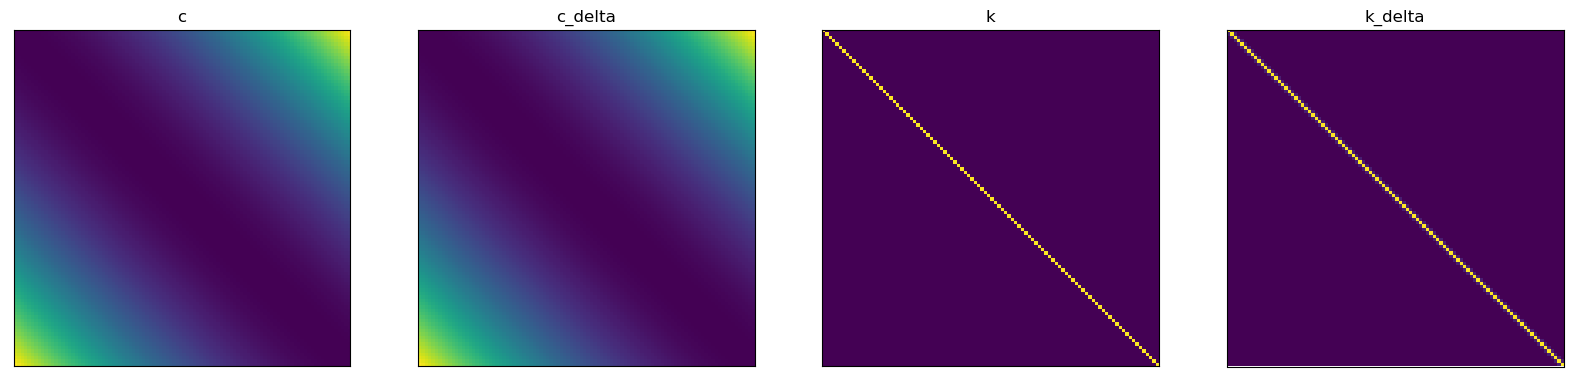

In [107]:
f, ax = plt.subplots(1, 4, figsize = (20,5))
plot_list = {    
   'c' : em_pd.c,
   'c_delta' : em_pd.c_delta,
   'k' : em_pd.k,
   'k_delta' : em_pd.k_delta
}
for i, key in enumerate(plot_list):
    ax[i].imshow(plot_list[key])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(key)
# plt.savefig('kernels.jpg')

## Compute Optimal Problem 

Following the algorithm 1 from Lacombe, we have created the function which calculates optimal transport and included it in the class of persistence diagrams. Here we check whether it gives reasonable results for different and same diagrams from our dataset.

<img src="alg1.png"/> 

In [109]:
print('Optimal Transport Problem between 0 and 1 \t', em_pd.optimal_transport(em_pd.histograms[0], em_pd.histograms[1]))
print('Optimal Transport Problem between 1 and 1 \t', em_pd.optimal_transport(em_pd.histograms[1], em_pd.histograms[1]))

Optimal Transport Problem between 0 and 1 	 3.000026544574845
Optimal Transport Problem between 1 and 1 	 4.9599818158434994e-08


Text(0.5,1,'Second PD from elo dataset')

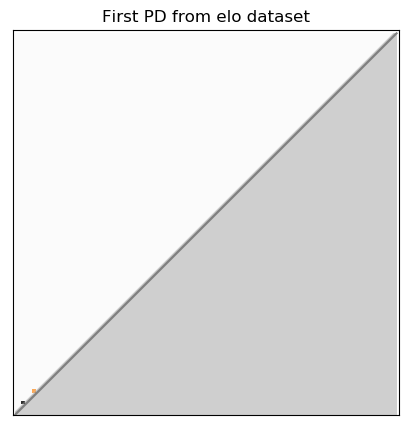

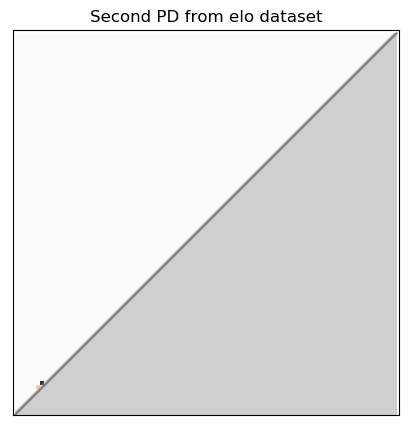

In [19]:
aftda.plot_histogram(em_pd.histograms[0])
plt.title('First PD from elo dataset')
aftda.plot_histogram(em_pd.histograms[1])
plt.title('Second PD from elo dataset')

However because our datasets are very sparse, we use artificial data to visualize and test the functions on them. For this purpose we created two blobs and moved one of them from another in order to see, how distance changes. 

Also we checked whether our algorithm indeed takes into consideration the mass of each histogram by creating and testing it on the blobs with different number of samples. The result you can see below.

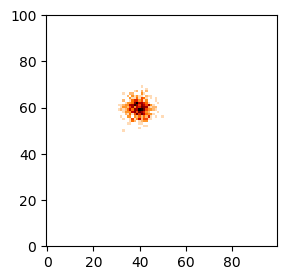

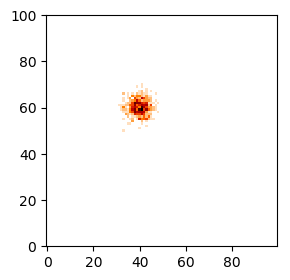

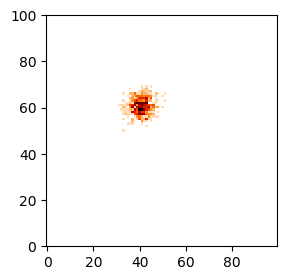

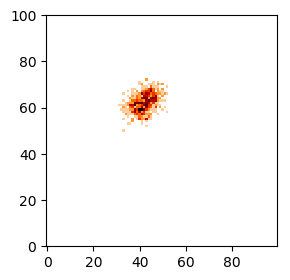

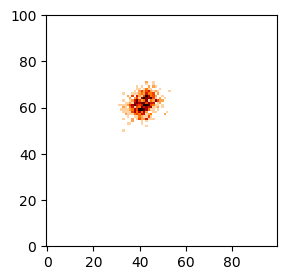

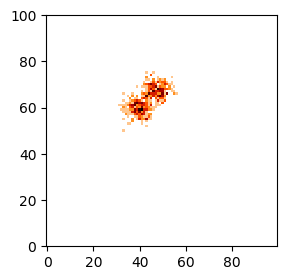

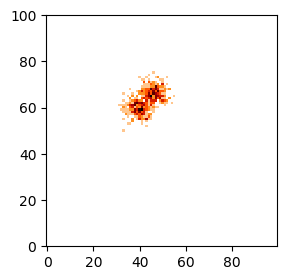

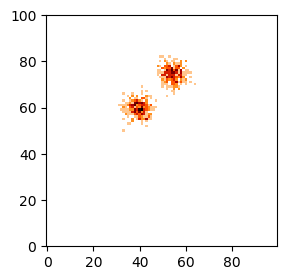

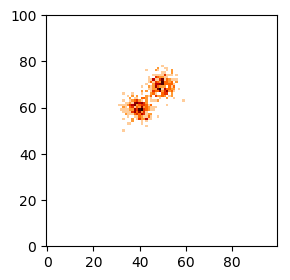

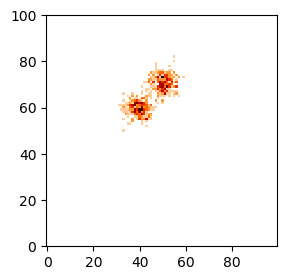

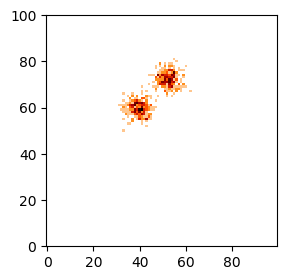

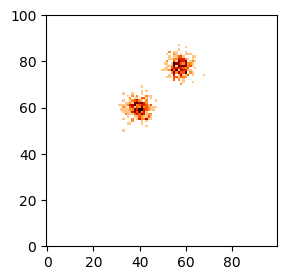

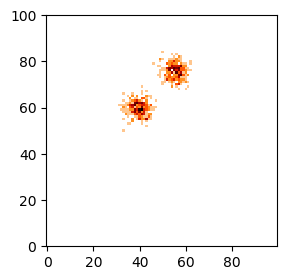

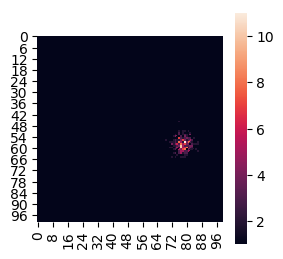

In [30]:
X, y = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(40, 20)], cluster_std=3)
blob_2 = np.ones((d, d))
for x in X:
    i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))
    if (i != j) and (i<j):
        blob_2[i][j] +=1 
# sns.heatmap(blob_2)
# plt.figure(2)
dist_list = []
dist_list_different = []
for k in range(0, 20):
    X, y = datasets.make_blobs(n_samples=350, n_features = 2, centers = [(40 + k, 20 + k)], cluster_std=3)
    blob_1 = np.ones((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    dist_list_different.append(em_pd.optimal_transport(blob_1, blob_2))
    
    
    X, y = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(40 + k, 20 + k)], cluster_std=3)
    blob_1 = np.ones((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    dist_list.append(em_pd.optimal_transport(blob_1, blob_2))
    plt.figure(i, figsize= (3,3), dpi = 100)
    plt.imshow((blob_1 + blob_2).T,  cmap = plt.cm.gist_heat_r)
    plt.ylim(0,100)
#     plt.savefig('blobs_' + str(k) + '.jpg',  )
sns.heatmap(blob_1)

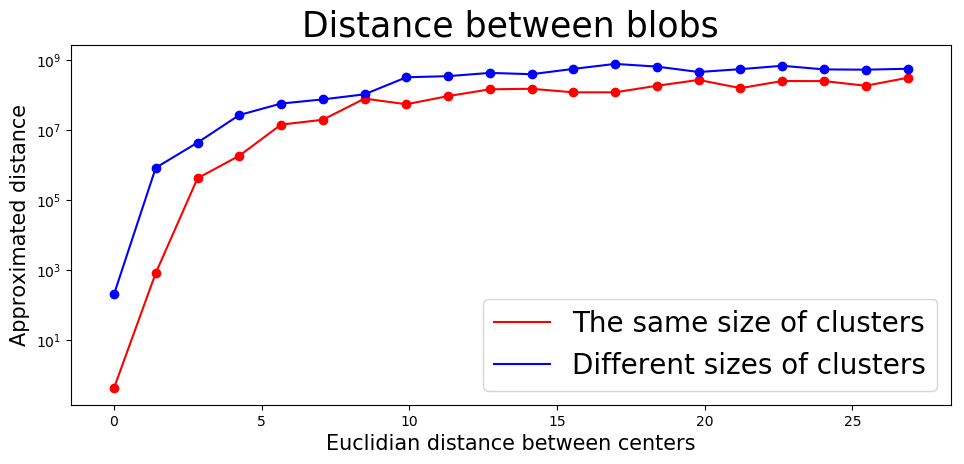

In [40]:
plt.figure(100, figsize= (10,5))
x = [np.sqrt(2*k**2) for k in range(20)]
plt.scatter(x , dist_list, c = 'r')
plt.semilogy(x, dist_list, c = 'r', label = 'The same size of clusters')

plt.scatter(x , dist_list_different, c = 'b')
plt.semilogy(x, dist_list_different, c = 'b', label = 'Different sizes of clusters')

plt.legend(loc = 'lower right', fontsize = 20)
plt.title('Distance between blobs', fontsize = 25)
plt.ylabel('Approximated distance', fontsize = 15)
plt.xlabel('Euclidian distance between centers', fontsize = 15)
plt.savefig('distance.jpg')
plt.tight_layout(pad = 2)

Here we presented gif with the moving blobs, to illustrate the approach. This was done for blobs of the same size.

<img src="giphy_new.gif"/><img src="giphy-2.gif"/> 

# Initialize `cmap`

In [14]:
import matplotlib

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0., 'white'), (0.4, 'yellow'), (1.0, 'red')])

## Barycenters

For the calculation of barycenters we implemented the second algorithm from the original paper, which is as follows:

<img src="alg2.png"/> 

Here we test our algorithm on the dataset with two blobs of different structure.

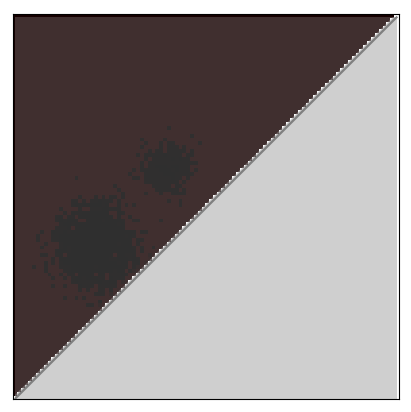

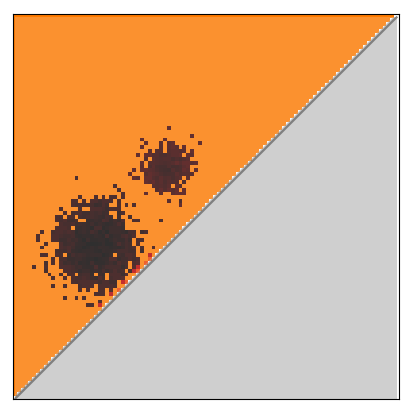

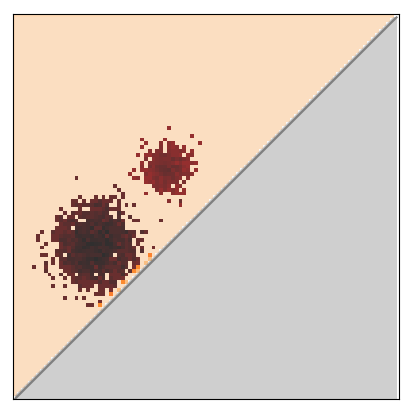

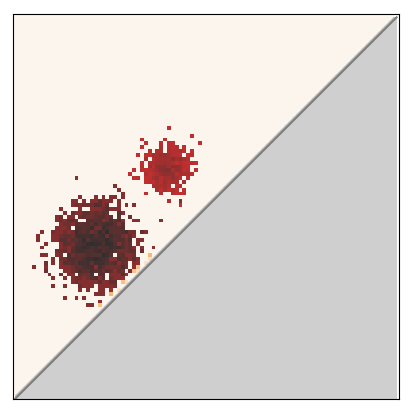

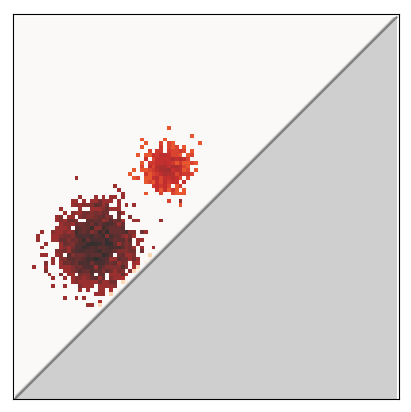

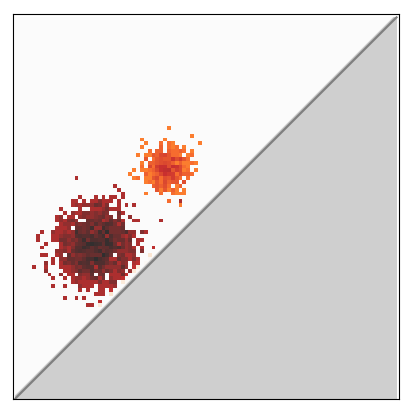

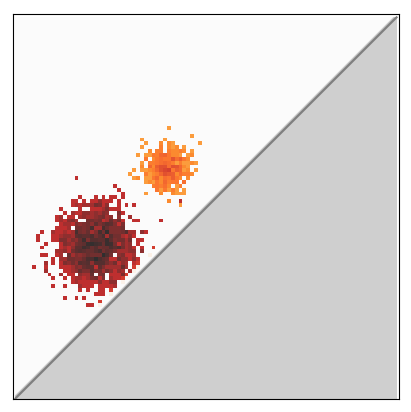

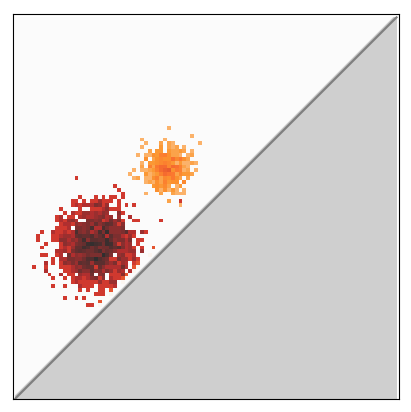

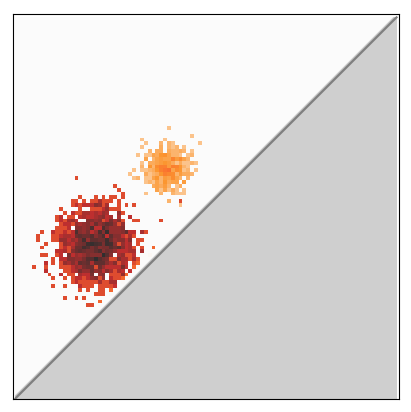

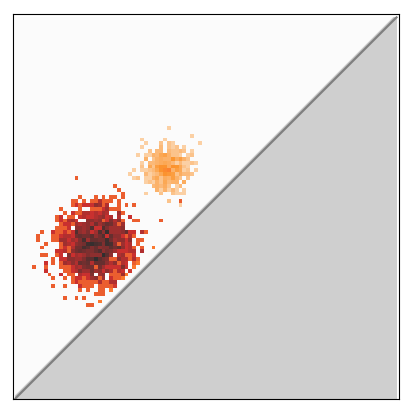

In [17]:
a_and_b = [blob_1,blob_2]
# a_and_b = [a,b]
# a_and_b = histograms[:3]
z, norm = em_pd.barycenter(a_and_b, 200, parallel=True, plots= 20)

Text(0.5, 0, 'Iterations')

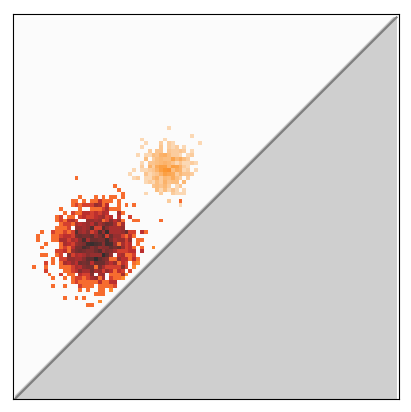

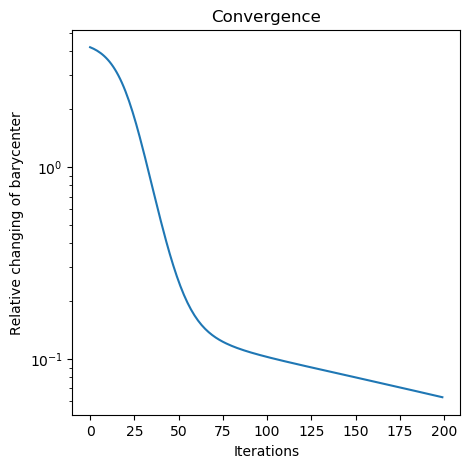

In [18]:
import seaborn as sns
aftda.plot_histogram(z)
plt.figure(2, figsize= (5,5))
plt.title("Convergence")
plt.semilogy(1000*np.array(norm))
plt.ylabel('Relative changing of barycenter')
plt.xlabel('Iterations')

### Let's try to process Real Data

Text(0.5,1,'Barycenter of top 20 histograms \n em_pd')

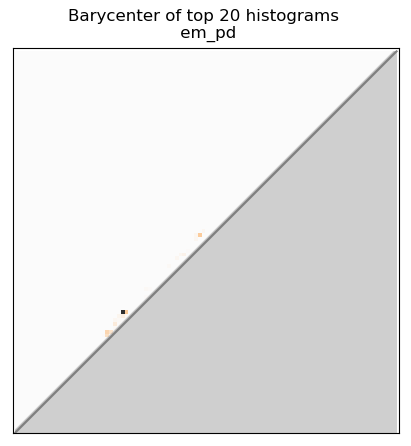

In [39]:
em_pd = aftda.persistence_diagram(em_PD, d, gamma, Lambda)
em_pd.masses.sort(reverse= True)
top_ind = []
for i in range(20):
    top_ind.append(em_pd.masses[i][1])
#     top_ind.append(em_pd.masses[500 + i][1])
top_hist = np.array(em_pd.histograms)[top_ind]
z, norm = em_pd.barycenter(top_hist, 20, parallel= True)
aftda.plot_histogram(z)
plt.title("Barycenter of top 20 histograms in em_pd")
# plt.savefig("barycenter.jpg")

## Create Artificial dataset of blobs for clustering

In [129]:
blobs = []
data_points = []
gamma = 0.2
Lambda = 0.1
for i in range(10):
    x = np.random.randint(0, 3)
    y = np.random.randint(0, 3)
    X, _ = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(20 + y - 1, 40 + x - 1)], cluster_std=3)
    blob_1 = np.zeros((d, d))
    for x in X:
        i, j =int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))%100, int(d*(x[1]+ 20)/(80+ 20 + 1.e-3))%100
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    
    data_points.append((0,X))
    x = np.random.randint(0, 3)
    y = np.random.randint(0, 3)
    X, _ = datasets.make_blobs(n_samples=600, n_features = 2, centers = [(40 + y - 1, 70 + x - 1)], cluster_std= 2)
    blob_2 = np.zeros((d, d))
    for x in X:
        i, j =int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))%100, int(d*(x[1]+ 20)/(80+ 20 + 1.e-3))%100
        if (i != j) and (i<j):
            blob_2[i][j] +=1 
    blobs.append(blob_1)
    blobs.append(blob_2)
    data_points.append((0, X))
blobs_pd = aftda.persistence_diagram(data_points, d, gamma, Lambda)

([], <a list of 0 Text yticklabel objects>)

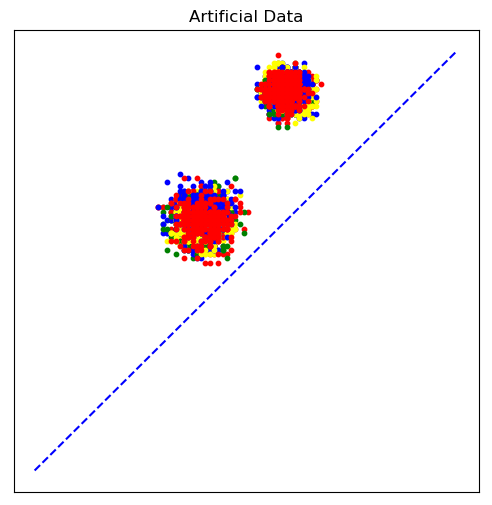

In [139]:
col = ['blue','r','g','yellow']
plt.figure(figsize= (6,6))
for i in range(len(blobs)):
    x = (data_points[i][1][:,0],  data_points[i][1][:,1])
    plt.scatter(((d*(x[0]+ 20)/(80+ 20 + 1.e-3)).astype(np.int))%100, ((d*(x[1]+ 20)/(80+ 20 + 1.e-3)).astype(np.int))%100, c =col[(i//2)%4], s= 10)

plt.plot([x for x in range(100)], [x for x in range(100)], 'b--',)
plt.title("Artificial Data")
plt.xticks(())
plt.yticks(())
# plt.savefig("artificial_data.jpg")

## KMeans clustering

### Sinkhorn Method

In [140]:
labels, centroids = blobs_pd.Kmeans(blobs, n_clusters = 2, metric= 'sinkhorn')

0
[1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0]
1
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
2
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


Text(0.5, 1.0, 'Second Center')

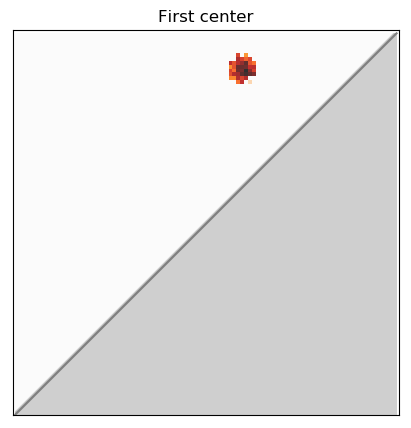

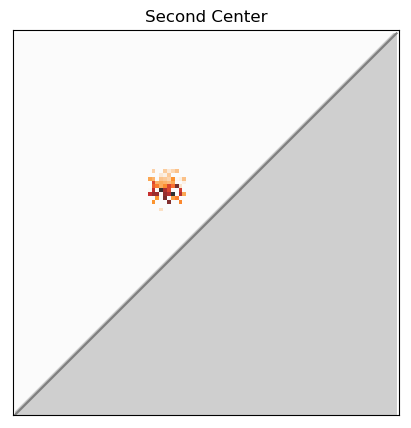

In [141]:
print(labels)
aftda.plot_histogram(centroids[0])
plt.title("First center")
aftda.plot_histogram(centroids[1])
plt.title("Second Center")

### Wasserstein method

0
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


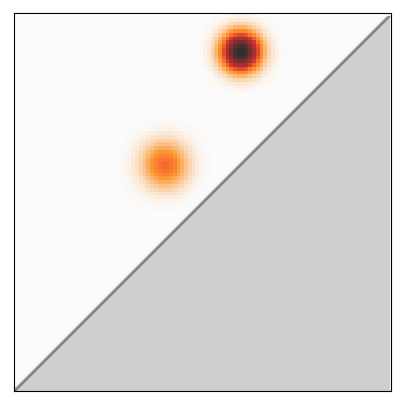

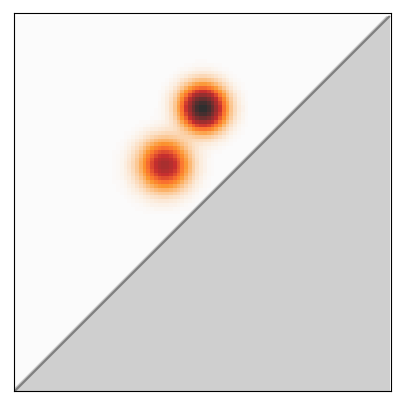

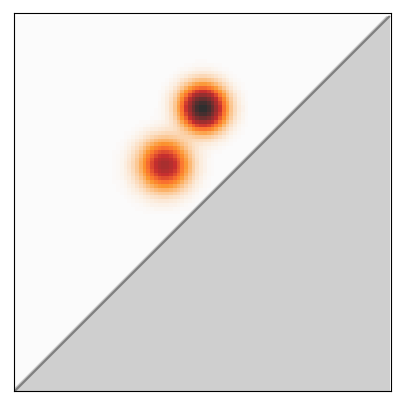

In [67]:
labels, centroinds = blobs_pd.Kmeans(blobs, n_clusters = 2, metric = 'wasser')

### Generate a Big Data for Complexity Analysis

In [36]:
blobs = []
data_points = []
d = 100
gamma = 0.2
Lambda = 0.1
for i in range(40):
    x = np.random.randint(0, 3)
    y = np.random.randint(0, 3)
    X, _ = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(20 + y - 1, 40 + x - 1)], cluster_std=3)
    blob_1 = np.zeros((d, d))
    for x in X:
        i, j =int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))%100, int(d*(x[1]+ 20)/(80+ 20 + 1.e-3))%100
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    data_points.append((0,X))
    
    x = np.random.randint(0, 3)
    y = np.random.randint(0, 3)
    X, _ = datasets.make_blobs(n_samples=600, n_features = 2, centers = [(40 + y - 1, 70 + x - 1)], cluster_std= 2)
    blob_2 = np.zeros((d, d))
    for x in X:
        i, j =int(d*(x[0]+ 20)/(100 + 20 + 1.e-3))%100, int(d*(x[1]+ 20)/(100 + 20 + 1.e-3))%100
        if (i != j) and (i<j):
            blob_2[i][j] +=1 
    data_points.append((0,X))         
    blobs.append(blob_1)
    blobs.append(blob_2)    
    data_points.append((0, X))
blobs_pd = aftda.persistence_diagram(data_points, d, gamma, Lambda)

In [ ]:
import time
tt = []
for k in [8,16,24,32,40]:
    start = time.time()
    labels, centroids = blobs_pd.Kmeans(blobs[:k], 2)
    end = time.time()
    tt.append(end - start)
# plt.plot(list(range(0, len(blobs), 8)), tt)

# Calculating barycenters

In [98]:
z, norm = blobs_pd.barycenter([blobs[0], blobs[2]], 201,  plots= 0)

## Convergence of finding barycenter
We implement Parallel and Sequential computing

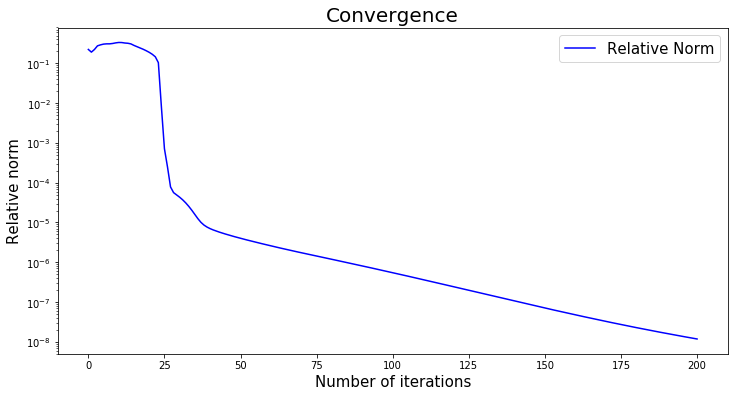

In [99]:
plt.figure(figsize=(12,6))
plt.semilogy(norm, c= 'b', label = 'Relative Norm')
plt.title('Convergence', fontsize = 20)
plt.xlabel("Number of iterations", fontsize = 15)
plt.ylabel("Relative norm", fontsize = 15)
plt.legend( fontsize = 15)
plt.savefig("convergence.jpg")

In [64]:
import time
tt1 = []
tt = []
for k in [8, 16, 24, 32, 40]:
    start = time.time()
    labels, centroids = blobs_pd.Kmeans(blobs[:k], 2, parallel = True)
    end = time.time()
    tt.append(end - start)
    start = time.time()
    labels, centroids = blobs_pd.Kmeans(blobs[:k], 2, parallel = False)
    end = time.time()
    tt1.append(end - start)


0
[1 0 0 0 0 1 1 1]
1
[1 0 0 0 1 0 1 0]
2
[1 0 1 0 1 0 1 0]
3
[1 0 1 0 1 0 1 0]
0
[0 1 0 0 0 0 0 1]
1
[0 1 0 1 0 1 0 1]
2
[0 1 0 1 0 1 0 1]
0
[0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1]
1
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
2
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
0
[0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1]
1
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
2
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
0
[0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0]
1
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
2
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
0
[0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0]
1
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
2
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
0
[1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1]
1
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
2
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
0
[1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0]
1
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1

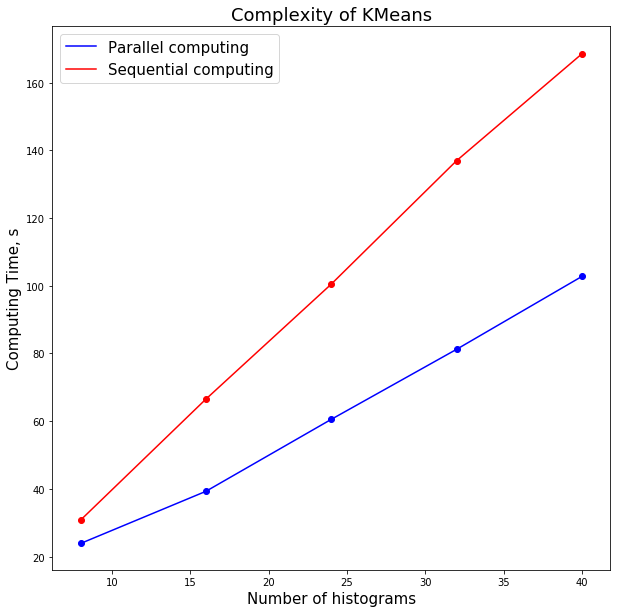

In [74]:
plt.figure(figsize=(10,10))
plt.plot(8*np.arange(len(tt)) + 8, tt, c= 'b', label = 'Parallel computing')
plt.scatter(8*np.arange(len(tt)) + 8 , tt, c= 'b')

plt.plot(8*np.arange(len(tt1)) + 8, tt1, c= 'r', label = 'Sequential computing')
plt.scatter(8*np.arange(len(tt1)) + 8 , tt1, c= 'r')

plt.title("Complexity of KMeans", fontsize=18)
plt.xlabel("Number of histograms", fontsize=15)
plt.ylabel("Computing Time, s", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Complexity.jpg')

0
[0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0]
1
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
2
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


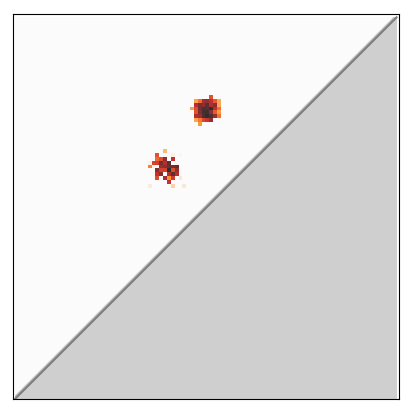

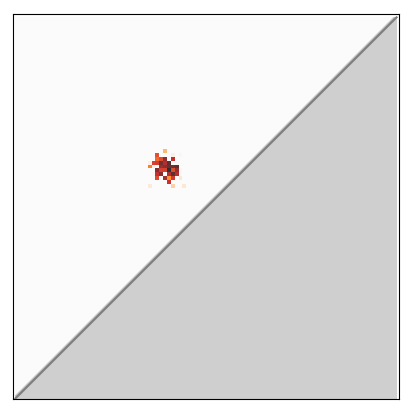

In [37]:
labels, centroids = blobs_pd.Kmeans(blobs[:20], 2, parallel = True)
aftda.plot_histogram(centroids[0]+centroids[1])
aftda.plot_histogram(centroids[1])

In [ ]:
hierarchical clusters, аггломеративный кластеринг
попарные расстояния
или случайная подвыборка (грубовато, но усреднение и норм)

1. спросить почему не работает вассерштейн, что не так 
2. аггломеративный кластеринг 
3. синкхорн, ньюмерикалли стэйбл, надо глянуть статьи про это дело, как это лучше считать
4. надо регуляризовать 
5. в аггломеративном идем пробовать вассерштейна и транспорт собственно 


6. нормализация временных рядов, по среднему и стандартному расхреначить нормализацию
7. не надо зацикливаться на персистентных диаграммах, искать другое 
8. считать быстро, устойчиво и на больших данных 
9. попробовать для баркодов или бетти сиквенсис 

через какое-то время посмотреть на задачу как на задачу исследования лосс поверхностей для нейронных сетей 
сделаем аггломеративную и пойдем в кластеризацию разных локальных оптимумов
тракетории 